## TURKISH
## Proje: Türkçe Metin Sınıflandırma
Bu projede, çeşitli Türkçe metinleri kategorilerine ayıran bir sınıflandırıcı geliştireceğiz. Kullanılacak model `SBERT` + `OPTICS` olacak.

Veri kaynağı: Datas/data.csv
Hedef: 'content' sütunundaki metni kullanarak 'category' sütununu tahmin etmek.


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import re

In [3]:

df = pd.read_csv('../../Datas/data.csv')
df.head()
df.sample(n=5)

,category,content
503,Ekonomi,AVRUKON Avrukon dan Konya ya yenilikçi plaza a...
1025,Spor,Türkiye Deplasmanlı Erkekler Voleybol Ligi 201...
1214,Spor,"2023 Avrupa Salon Okçuluk Şampiyonası, 19-24 Ş..."
1251,Spor,"2025 Avrupa Salon Okçuluk Şampiyonası, 17-23 Ş..."
1226,Spor,"2023 Türkiye Halter Şampiyonası, Mehmet Emin A..."


## İlk Gözlem
- `content`: metin verisi
- `category`: hedef sınıf (etiket)

%%
Boş değerleri sil.
Küçük harfe çevir.
Noktalama ve sayıları temizle.
Stopwords temizliği yap.
Stemming bu projede opsiyonel

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df.dropna(subset=['content', 'category'], inplace=True)
df['processed_data'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: xlabel='category'>

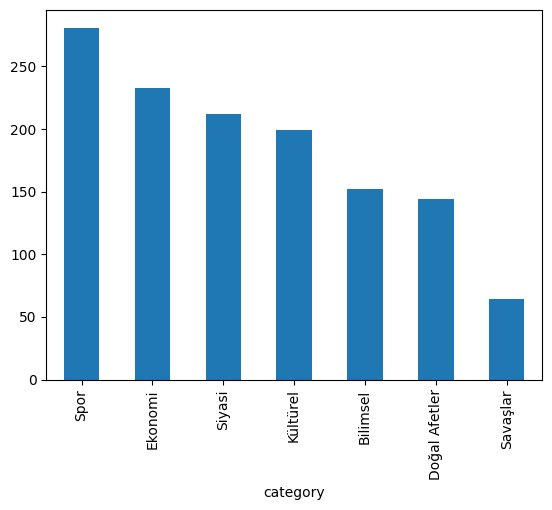

In [5]:
# Kategori dağılımını grafikle veya tabloda gör
df['category'].value_counts().plot(kind='bar')

In [6]:
from sentence_transformers import SentenceTransformer

# Türkçe metinler için uygun, hızlı bir SBERT modeli:
sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Embedding üretimi
X = sbert_model.encode(df['processed_data'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

In [7]:
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import Counter
import numpy as np
import pandas as pd # df'i kullanabilmek için ekledim
# X, df['category'] gibi değişkenlerin önceki hücrelerden tanımlanmış olduğunu varsayıyorum.
# Örneğin:
# X = sbert_model.encode(df['processed_data'].tolist(), show_progress_bar=True)
# df = pd.read_csv('../../Datas/data.csv') # Eğer df tanımlı değilse

# --- OPTICS ALGORİTMASI İLE KÜMELEME ---

# OPTICS algoritması
# min_samples: Bir kümenin çekirdek noktası olabilmek için gerekli minimum örnek sayısı.
#              Kümenin ne kadar yoğun olmasını beklediğinizi belirler.
# xi: Belirli bir kümenin ne kadar 'düz' olduğunu belirler. Daha küçük değerler daha esnek kümeler oluşturur.
#     Genellikle 0.05 gibi bir değerle başlanır.
# min_cluster_size: Bir kümenin olarak kabul edilmesi için gerekli minimum örnek sayısı.
#                   Bu değeri kategorilerin sayısına yakın ayarlayabilirsiniz.
#                   Kategorilerin 7 adet olduğunu varsayarsak, bu değeri deneyerek bulmak önemli.
optics_model = OPTICS(min_samples=15, xi=0.05, min_cluster_size=7) # Bu parametreleri verinize göre ayarlamanız gerekebilir.

# Kümeleme işlemini uygula
optics_model.fit(X)

# Küme atamalarını al
# OPTICS, atama yapamadığı gürültü noktalarını -1 olarak işaretler.
clusters = optics_model.labels_

# OPTICS kümelemede gürültü noktaları (-1 etiketli) bulunabilir.
# Bu noktaları çıkararak veya ayrı bir 'Noise' kategorisi olarak işleyerek devam edebilirsiniz.
# Şimdilik, sadece atanmış kümelere sahip noktaları değerlendireceğiz.
valid_indices = clusters != -1
valid_clusters = clusters[valid_indices]
valid_true_categories = df['category'].values[valid_indices]

df['cluster'] = -1 # Önce tümünü -1 (gürültü) olarak ayarla
df.loc[valid_indices, 'cluster'] = valid_clusters # Sonra geçerli kümelere ata

print("OPTICS Küme Atamaları (İlk 5):")
print(df[['category', 'cluster']].head())
print("\nOPTICS Küme Atamaları (Rastgele 5 Örnek):")
print(df.sample(n=5))

# --- KÜME-ETİKET EŞLEŞTİRMESİ VE DOĞRULUK HESAPLAMASI ---

le = LabelEncoder()
labels_num = le.fit_transform(df['category'])

cluster_label_map = {}
# Sadece geçerli küme ID'leri üzerinde döngü yapın (gürültü etiketi -1'i hariç tutun)
for cluster_id in np.unique(valid_clusters):
    if cluster_id == -1: # Zaten valid_clusters'tan çıkarıldığı için bu kontrol gereksiz ama emin olmak için
        continue
    
    mask = (clusters == cluster_id)
    # Atanmış etiketleri ve orijinal kategorileri al
    cluster_labels = labels_num[mask]
    
    if len(cluster_labels) == 0:
        continue
    
    # Kümedeki en yaygın orijinal kategoriyi bul
    most_common_num = Counter(cluster_labels).most_common(1)[0][0]
    cluster_label_map[cluster_id] = most_common_num

# Sayısal etiketleri orijinal kategori isimlerine geri çevir
cluster_label_map_str = {cluster_id: le.inverse_transform([num])[0]
                             for cluster_id, num in cluster_label_map.items()}

# Tahmin edilen kategorileri oluştur
# Geçerli indeksler için tahminleri atıyoruz, gürültü noktalarını ele almamız gerekiyor.
# Basit bir yaklaşım olarak, gürültü noktalarını tahmin dışı bırakabiliriz.
predicted_num_categories_all = np.full(len(df), -1) # Varsayılan olarak -1 atayalım
for i, c in enumerate(clusters):
    if c != -1 and c in cluster_label_map: # Gürültü olmayan ve eşleşme yapılan kümeler için
        predicted_num_categories_all[i] = cluster_label_map[c]

# Sadece gürültü olmayan noktalar için doğruluk hesaplayalım
# Veya gürültü noktalarını ayrı bir kategori olarak ele alıp hesaplayabilirsiniz.
# Burada, sadece eşleşen kümelere ait noktaları değerlendiriyoruz.
predicted_categories_filtered = le.inverse_transform(predicted_num_categories_all[valid_indices])
true_categories_filtered = df['category'].values[valid_indices]

accuracy = accuracy_score(true_categories_filtered, predicted_categories_filtered)

print(f"\nOPTICS doğruluk (gürültü dışı bırakılarak): {accuracy:.4f}")
print("Küme ID'lerinin Atandığı Kategoriler:")
for cid, cat in cluster_label_map_str.items():
    print(f"Cluster {cid} -> {cat}")

print(f"\nOPTICS toplam küme sayısı (gürültü hariç): {len(np.unique(valid_clusters))}")
print(f"Gürültü olarak sınıflandırılan örnek sayısı: {np.sum(clusters == -1)}")

n_real_categories = df['category'].nunique()
n_valid_clusters = len(np.unique(clusters[clusters != -1]))

print(f"Gerçek kategori sayısı: {n_real_categories}")
print(f"OPTICS ile elde edilen geçerli küme sayısı: {n_valid_clusters}")

OPTICS Küme Atamaları (İlk 5):
  category  cluster
0   Siyasi       -1
1   Siyasi       -1
2   Siyasi       -1
3   Siyasi       -1
4   Siyasi       -1

OPTICS Küme Atamaları (Rastgele 5 Örnek):
           category                                            content  \
84         Bilimsel  Turhan Alçelik, (d. 5 Mart 1958, Giresun) göz ...   
1282  Doğal Afetler  1922 Manisa yangını 5 Eylül 1922 gecesi başlad...   
513         Ekonomi  ı.K öculünun şano o..c.u 265 proje gerçekleşti...   
273   Doğal Afetler  1943 Adapazarı-Hendek depremi 20 Haziran yerel...   
924          Siyasi  1968 Türkiye Cumhuriyeti Milletvekili Ara Seçi...   

                                         processed_data  cluster  
84    turhan alçelik d mart giresun göz hekimi eski ...       -1  
1282  manisa yangını eylül gecesi başladı eylüle kad...       -1  
513   ık öculünun şano ocu proje gerçekleştirdi arçe...       -1  
273   adapazarıhendek depremi haziran yerel saat mey...       -1  
924   türkiye cumhuriyeti 

In [8]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import json
import os

# Gürültü dışı indeksleri seç
filtered_X = X[valid_indices]
filtered_clusters = clusters[valid_indices]

# Performans metriklerini hesapla
optics_sil = silhouette_score(filtered_X, filtered_clusters)
optics_calinski = calinski_harabasz_score(filtered_X, filtered_clusters)
optics_davies = davies_bouldin_score(filtered_X, filtered_clusters)

# --- METRIKLERİN HAZIRLANMASI ---
benchmark_entry = {
    "vectorizer": "SBERT",
    "cluster_model": "OPTICS",
    "accuracy": float(round(accuracy, 4)),
    "silhouette": float(round(optics_sil, 4)),
    "calinski_harabasz": float(round(optics_calinski, 4)),
    "davies_bouldin": float(round(optics_davies, 4))
}

# --- DOSYA YOLU BELİRT ---
benchmark_path = "../../Outputs/benchmark.json"

# --- VARSA OKU, YOKSA YENİ OLUŞTUR ---
if os.path.exists(benchmark_path):
    with open(benchmark_path, "r", encoding="utf-8") as f:
        try:
            benchmark_data = json.load(f)
        except json.JSONDecodeError:
            benchmark_data = []
else:
    benchmark_data = []

# --- YENİ VERİYİ EKLE ---
benchmark_data.append(benchmark_entry)

# --- DOSYAYA YAZ ---
with open(benchmark_path, "w", encoding="utf-8") as f:
    json.dump(benchmark_data, f, indent=4, ensure_ascii=False)

print("✅ OPTICS metrikleri benchmark.json dosyasına eklendi.")


✅ OPTICS metrikleri benchmark.json dosyasına eklendi.


In [9]:
import joblib
import os

target_base_dir = '../../Models/SBERT'

# Modelin tam kaydedileceği yol
model_save_path = os.path.join(target_base_dir, 'optics_model.joblib')

try:
    # Hedef dizini oluştur. exist_ok=True sayesinde zaten varsa hata vermez.
    os.makedirs(target_base_dir, exist_ok=True)
    print(f"'{target_base_dir}' dizini başarıyla oluşturuldu veya zaten mevcut.")
    print(f"Modelin kaydedileceği tam yol: {os.path.abspath(model_save_path)}") # Tam yolu gösterelim
except Exception as e:
    print(f"Dizin oluşturulurken bir hata oluştu: {e}")
    exit()


# Modeli kaydet
try:
    joblib.dump(optics_model, model_save_path)
    print(f"Model '{model_save_path}' konumuna başarıyla kaydedildi.")
    joblib.dump(X, '../../Models/SBERT/embeddings.joblib')
    print(f"Embeddings '{model_save_path}' konumuna başarıyla kaydedildi.")

except Exception as e:
    print(f"Model kaydedilirken bir hata oluştu: {e}")

'../../Models/SBERT' dizini başarıyla oluşturuldu veya zaten mevcut.
Modelin kaydedileceği tam yol: c:\Users\uslan\OneDrive\Desktop\CENG Notes\3.Sınıf Dersleri\Machine Learning\Dejaview-CENG3522\Models\SBERT\optics_model.joblib
Model '../../Models/SBERT\optics_model.joblib' konumuna başarıyla kaydedildi.
Embeddings '../../Models/SBERT\optics_model.joblib' konumuna başarıyla kaydedildi.


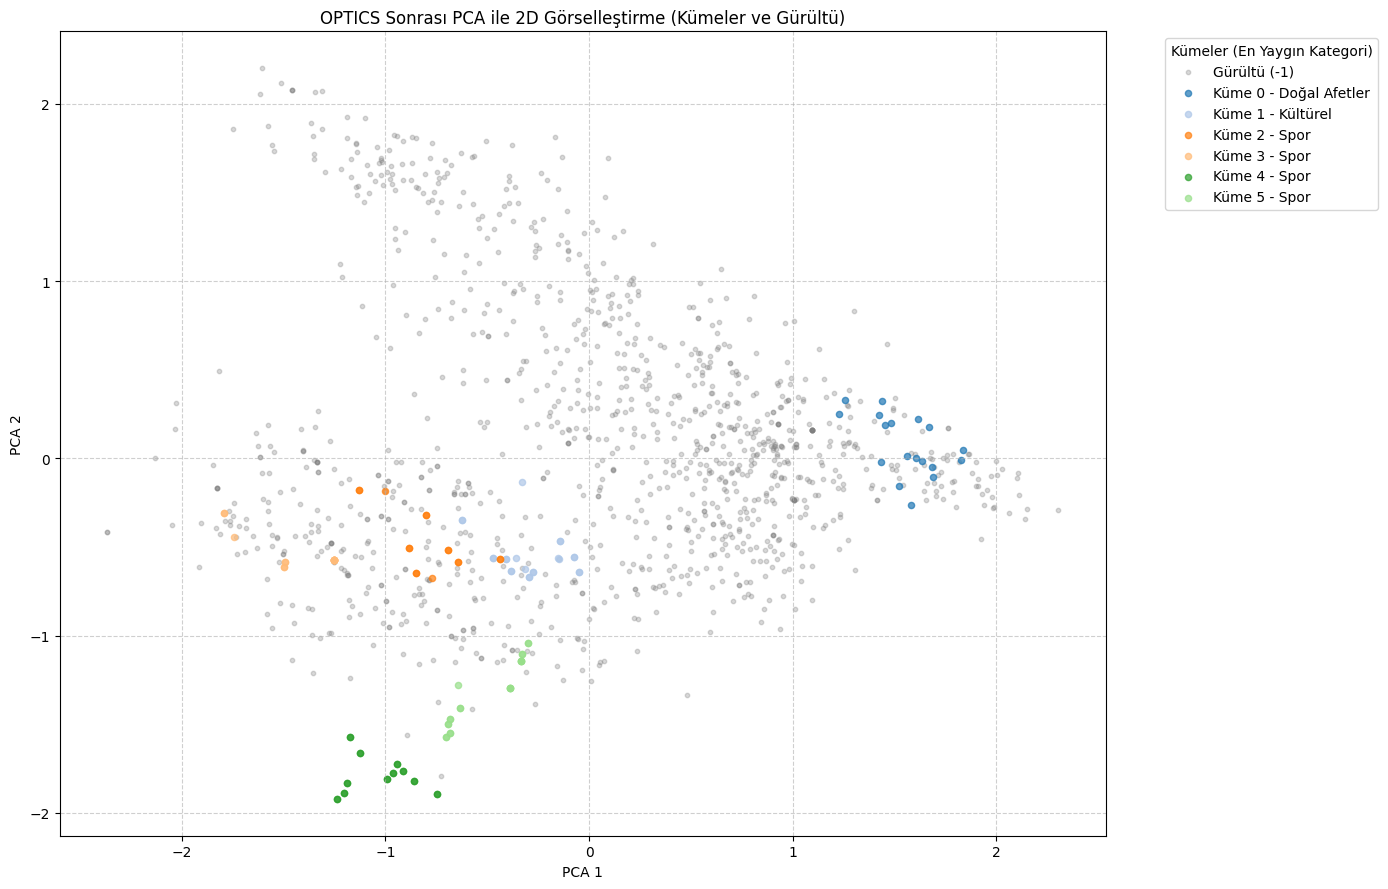

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# X, clusters, cluster_label_map_str gibi değişkenlerin önceki hücrelerden tanımlanmış olduğunu varsayıyorum.

# PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(14, 9)) # Figür boyutunu biraz büyüttüm

# --- Kümeleme noktalarını görselleştir ---
# Benzersiz küme ID'lerini al. -1 gürültü noktalarını temsil eder.
unique_clusters = np.unique(clusters)
# Gürültü dışındaki küme ID'lerini ayır
# (Bu, etiket haritalamasında kullanılacak asıl kümelerdir)
valid_clusters_ids = unique_clusters[unique_clusters != -1]

# Renk döngüsü için 10'dan fazla küme veya gürültü etiketiniz varsa sorun yaşamamak için
# colors = plt.cm.get_cmap('tab20', len(valid_clusters_ids) + 1).colors # +1 gürültü için veya sadece validler için
colors = plt.cm.tab20.colors # tab20 daha fazla renk sağlar (20 farklı renk)

# Gürültü noktalarını çiz (varsa)
if -1 in unique_clusters:
    noise_idx = np.where(clusters == -1)
    plt.scatter(X_pca[noise_idx, 0], X_pca[noise_idx, 1],
                color='gray', # Gürültü noktalarını gri renkte göster
                label='Gürültü (-1)',
                alpha=0.3, # Daha şeffaf yaparak ayırt et
                s=10) # Nokta boyutunu küçült

# Gürültü dışındaki kümeleri çiz
for i, cluster_id in enumerate(valid_clusters_ids):
    idx = np.where(clusters == cluster_id)
    # Renk ataması yaparken, gürültü -1 olduğu için renk indeksini düzgün ayarlamamız gerekebilir
    # Veya colors dizisinin indeksini doğrudan kullanabiliriz.
    
    # cluster_label_map_str içinde cluster_id'nin olup olmadığını kontrol etmek iyi bir pratiktir
    label_text = f"Küme {cluster_id}"
    if cluster_id in cluster_label_map_str:
        label_text += f" - {cluster_label_map_str[cluster_id]}"
    
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[i % len(colors)], # Renk döngüsünü ayarla
                label=label_text,
                alpha=0.7,
                s=20) # Nokta boyutunu ayarla


plt.title('OPTICS Sonrası PCA ile 2D Görselleştirme (Kümeler ve Gürültü)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title="Kümeler (En Yaygın Kategori)", bbox_to_anchor=(1.05, 1), loc='upper left') # Legend'ı dışarı taşıdım
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Grafiğin sıkışmamasını sağlar
plt.show()

## Grafik: Gerçek ve Tahmin Edilen Oranlar

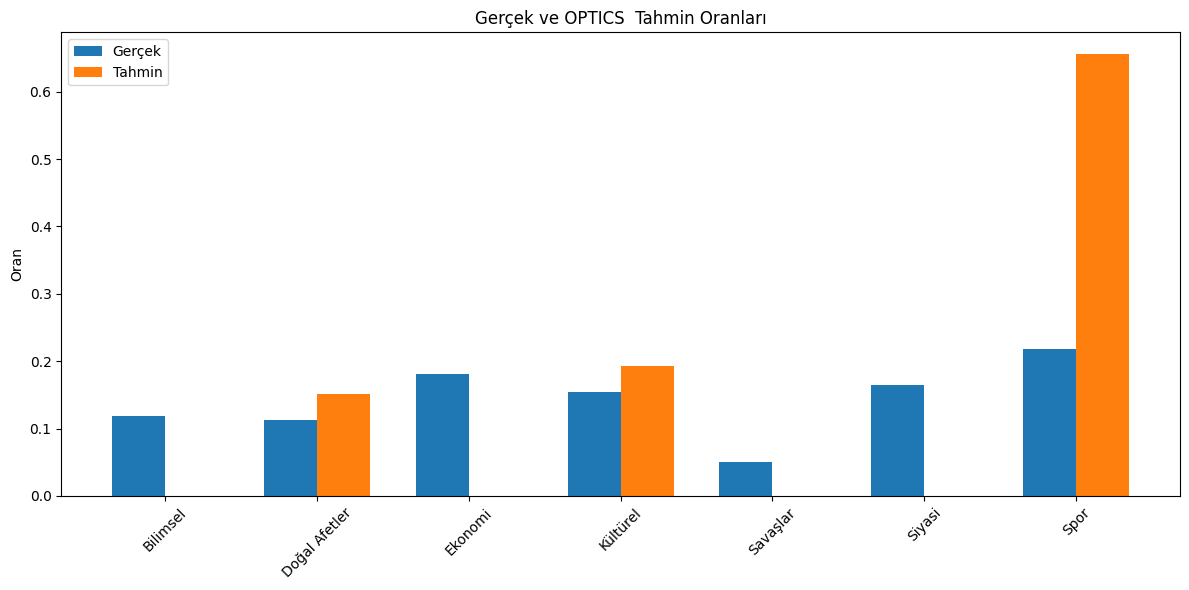

In [11]:

true_counts = df['category'].value_counts(normalize=True).sort_index()
predicted_categories = le.inverse_transform(predicted_num_categories_all[valid_indices])
predicted_counts = pd.Series(predicted_categories_filtered).value_counts(normalize=True).sort_index()


all_categories = sorted(set(true_counts.index).union(predicted_counts.index))
true_vals = [true_counts.get(cat, 0) for cat in all_categories]
predicted_vals = [predicted_counts.get(cat, 0) for cat in all_categories]

x = np.arange(len(all_categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, true_vals, width, label='Gerçek')
ax.bar(x + width/2, predicted_vals, width, label='Tahmin')
ax.set_ylabel('Oran')
ax.set_title('Gerçek ve OPTICS  Tahmin Oranları')
ax.set_xticks(x)
ax.set_xticklabels(all_categories, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


